In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1337)  # for reproducibility

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import TensorBoard

def setGPU():   
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    set_session(tf.Session(config=config))
#setGPU()

print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


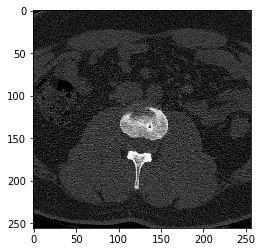

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')



In [7]:
import random
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Multiply(),
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.ContrastNormalization(),
    iaa.MedianBlur(),
])

def batch():
    size = 256
    num_of_output = 10
    num_of_img = X_train.shape[0]
    
    random_list = random.sample(range(num_of_img), num_of_output)
    #print(random_list)
    
    data_shape = (num_of_output, size, size, 1)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num_of_output):
        X[i] = X_train[random_list[i]]
        Y[i] = Y_train[random_list[i]]
        
    X = seq.augment_images(X)
        
    return X, Y
#batch(X_train, Y_train)
    

In [8]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()

/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:

# training
nb_epoch = 1000
for e in range(nb_epoch):
    print("epoch %d" % e)
    X_batch, Y_batch = batch()
    model.fit(X_batch, Y_batch)

epoch 0
Epoch 1/1
10/10 [==============================] - 10s 974ms/step - loss: 0.7021 - acc: 0.1068
epoch 1
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.6831 - acc: 0.8843
epoch 2
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.6619 - acc: 0.8952
epoch 3
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.5949 - acc: 0.9084
epoch 4
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.4514 - acc: 0.9069
epoch 5
Epoch 1/1
10/10 [==============================] - 1s 63ms/step - loss: 0.6958 - acc: 0.9006
epoch 6
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.5099 - acc: 0.9029
epoch 7
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.4695 - acc: 0.8935
epoch 8
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.5278 - acc: 0.8871
epoch 9
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.5491 - 

epoch 81
Epoch 1/1
10/10 [==============================] - 1s 63ms/step - loss: 0.0754 - acc: 0.9099
epoch 82
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0829 - acc: 0.9001
epoch 83
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0771 - acc: 0.9085
epoch 84
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0593 - acc: 0.9299
epoch 85
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0670 - acc: 0.9192
epoch 86
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0680 - acc: 0.9178
epoch 87
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0706 - acc: 0.9144
epoch 88
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0527 - acc: 0.9400
epoch 89
Epoch 1/1
10/10 [==============================] - 1s 62ms/step - loss: 0.0778 - acc: 0.9114
epoch 90
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0

epoch 161
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0534 - acc: 0.9196
epoch 162
Epoch 1/1
10/10 [==============================] - 1s 61ms/step - loss: 0.0729 - acc: 0.8922
epoch 163
Epoch 1/1
10/10 [==============================] - 1s 62ms/step - loss: 0.0638 - acc: 0.9044
epoch 164
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0548 - acc: 0.9162
epoch 165
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0615 - acc: 0.9103
epoch 166
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0701 - acc: 0.8944
epoch 167
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0802 - acc: 0.8820
epoch 168
Epoch 1/1
10/10 [==============================] - 1s 76ms/step - loss: 0.0582 - acc: 0.9121
epoch 169
Epoch 1/1
10/10 [==============================] - 1s 81ms/step - loss: 0.0642 - acc: 0.9060
epoch 170
Epoch 1/1
10/10 [==============================] - 1s 73ms/step

epoch 241
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0587 - acc: 0.9549
epoch 242
Epoch 1/1
10/10 [==============================] - 1s 62ms/step - loss: 0.0554 - acc: 0.9548
epoch 243
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0700 - acc: 0.9425
epoch 244
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0615 - acc: 0.9459
epoch 245
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0525 - acc: 0.9546
epoch 246
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0507 - acc: 0.9606
epoch 247
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0467 - acc: 0.9630
epoch 248
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0456 - acc: 0.9631
epoch 249
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0678 - acc: 0.9497
epoch 250
Epoch 1/1
10/10 [==============================] - 1s 64ms/step

epoch 321
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0473 - acc: 0.9605
epoch 322
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0466 - acc: 0.9594
epoch 323
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0551 - acc: 0.9566
epoch 324
Epoch 1/1
10/10 [==============================] - 1s 63ms/step - loss: 0.0526 - acc: 0.9617
epoch 325
Epoch 1/1
10/10 [==============================] - 1s 62ms/step - loss: 0.0605 - acc: 0.9534
epoch 326
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0727 - acc: 0.9447
epoch 327
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0473 - acc: 0.9641
epoch 328
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0514 - acc: 0.9554
epoch 329
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0549 - acc: 0.9541
epoch 330
Epoch 1/1
10/10 [==============================] - 1s 68ms/step

epoch 401
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0493 - acc: 0.9606
epoch 402
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0500 - acc: 0.9558
epoch 403
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0640 - acc: 0.9488
epoch 404
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0659 - acc: 0.9457
epoch 405
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0648 - acc: 0.9508
epoch 406
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0435 - acc: 0.9674
epoch 407
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0552 - acc: 0.9551
epoch 408
Epoch 1/1
10/10 [==============================] - 1s 73ms/step - loss: 0.0705 - acc: 0.9402
epoch 409
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0595 - acc: 0.9502
epoch 410
Epoch 1/1
10/10 [==============================] - 1s 72ms/step

epoch 481
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0484 - acc: 0.9546
epoch 482
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0538 - acc: 0.9627
epoch 483
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0344 - acc: 0.9709
epoch 484
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0488 - acc: 0.9643
epoch 485
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0526 - acc: 0.9572
epoch 486
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0672 - acc: 0.9488
epoch 487
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0581 - acc: 0.9533
epoch 488
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0521 - acc: 0.9499
epoch 489
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0465 - acc: 0.9618
epoch 490
Epoch 1/1
10/10 [==============================] - 1s 68ms/step

epoch 561
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0456 - acc: 0.9623
epoch 562
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0662 - acc: 0.9479
epoch 563
Epoch 1/1
10/10 [==============================] - 1s 72ms/step - loss: 0.0451 - acc: 0.9600
epoch 564
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0413 - acc: 0.9681
epoch 565
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0360 - acc: 0.9718
epoch 566
Epoch 1/1
10/10 [==============================] - 1s 86ms/step - loss: 0.0580 - acc: 0.9502
epoch 567
Epoch 1/1
10/10 [==============================] - 1s 74ms/step - loss: 0.0503 - acc: 0.9559
epoch 568
Epoch 1/1
10/10 [==============================] - 1s 74ms/step - loss: 0.0469 - acc: 0.9617
epoch 569
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0511 - acc: 0.9584
epoch 570
Epoch 1/1
10/10 [==============================] - 1s 70ms/step

epoch 641
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0501 - acc: 0.9553
epoch 642
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0535 - acc: 0.9566
epoch 643
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0629 - acc: 0.9503
epoch 644
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0597 - acc: 0.9513
epoch 645
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0527 - acc: 0.9543
epoch 646
Epoch 1/1
10/10 [==============================] - 1s 63ms/step - loss: 0.0661 - acc: 0.9476
epoch 647
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0602 - acc: 0.9521
epoch 648
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0449 - acc: 0.9637
epoch 649
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0528 - acc: 0.9572
epoch 650
Epoch 1/1
10/10 [==============================] - 1s 68ms/step

epoch 721
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0636 - acc: 0.9470
epoch 722
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0480 - acc: 0.9590
epoch 723
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0397 - acc: 0.9657
epoch 724
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0559 - acc: 0.9551
epoch 725
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0543 - acc: 0.9580
epoch 726
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0467 - acc: 0.9637
epoch 727
Epoch 1/1
10/10 [==============================] - 1s 72ms/step - loss: 0.0486 - acc: 0.9599
epoch 728
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0460 - acc: 0.9589
epoch 729
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0459 - acc: 0.9648
epoch 730
Epoch 1/1
10/10 [==============================] - 1s 63ms/step

epoch 801
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0541 - acc: 0.9585
epoch 802
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0594 - acc: 0.9522
epoch 803
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0565 - acc: 0.9534
epoch 804
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0537 - acc: 0.9545
epoch 805
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0458 - acc: 0.9632
epoch 806
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0650 - acc: 0.9512
epoch 807
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0482 - acc: 0.9600
epoch 808
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0589 - acc: 0.9543
epoch 809
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0458 - acc: 0.9589
epoch 810
Epoch 1/1
10/10 [==============================] - 1s 69ms/step

epoch 881
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0563 - acc: 0.9542
epoch 882
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0451 - acc: 0.9659
epoch 883
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0567 - acc: 0.9567
epoch 884
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0460 - acc: 0.9633
epoch 885
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0502 - acc: 0.9549
epoch 886
Epoch 1/1
10/10 [==============================] - 1s 73ms/step - loss: 0.0437 - acc: 0.9614
epoch 887
Epoch 1/1
10/10 [==============================] - 1s 71ms/step - loss: 0.0435 - acc: 0.9639
epoch 888
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.0457 - acc: 0.9616
epoch 889
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0468 - acc: 0.9609
epoch 890
Epoch 1/1
10/10 [==============================] - 1s 67ms/step

epoch 961
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0453 - acc: 0.9588
epoch 962
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0584 - acc: 0.9523
epoch 963
Epoch 1/1
10/10 [==============================] - 1s 69ms/step - loss: 0.0539 - acc: 0.9572
epoch 964
Epoch 1/1
10/10 [==============================] - 1s 65ms/step - loss: 0.0461 - acc: 0.9593
epoch 965
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.0640 - acc: 0.9467
epoch 966
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.0585 - acc: 0.9490
epoch 967
Epoch 1/1
10/10 [==============================] - 1s 73ms/step - loss: 0.0535 - acc: 0.9610
epoch 968
Epoch 1/1
10/10 [==============================] - 1s 64ms/step - loss: 0.0588 - acc: 0.9577
epoch 969
Epoch 1/1
10/10 [==============================] - 1s 66ms/step - loss: 0.0515 - acc: 0.9556
epoch 970
Epoch 1/1
10/10 [==============================] - 1s 63ms/step

In [10]:
# save
model.save('./save/model_unet.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model

In [11]:
# load
model = load_model('./save/model_unet.h5')

/home/ian/.local/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


(1, 256, 256, 1)


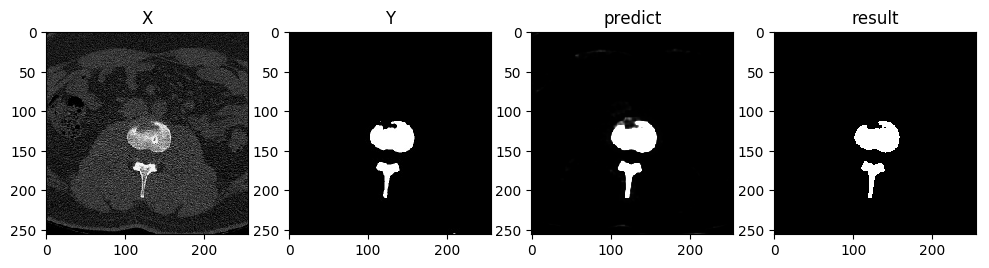

(1, 256, 256, 1)


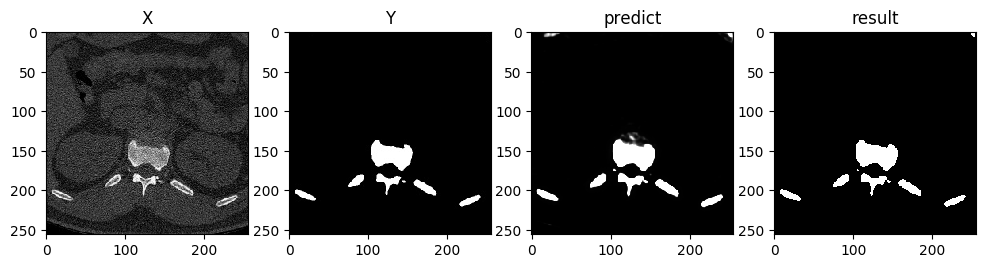

(1, 256, 256, 1)


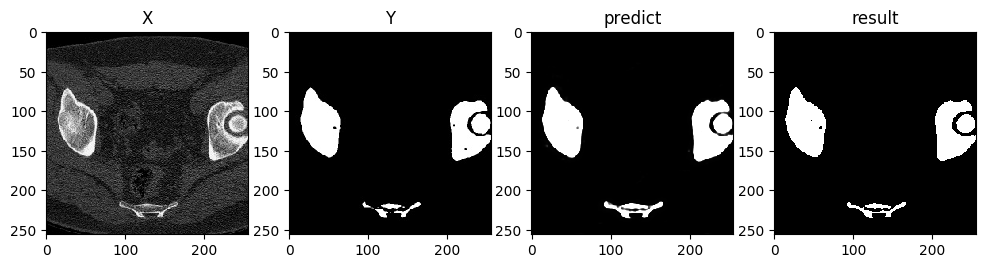

(1, 256, 256, 1)


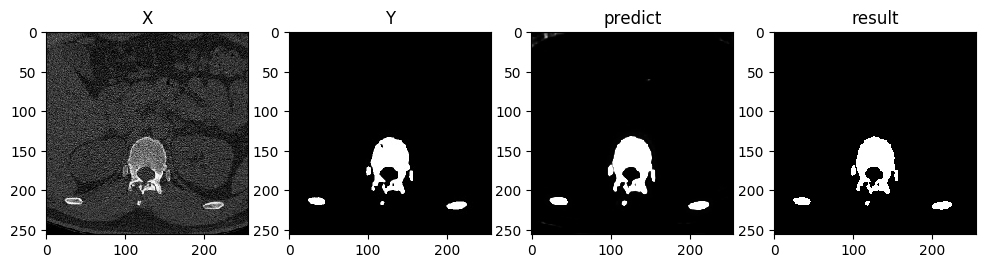

(1, 256, 256, 1)


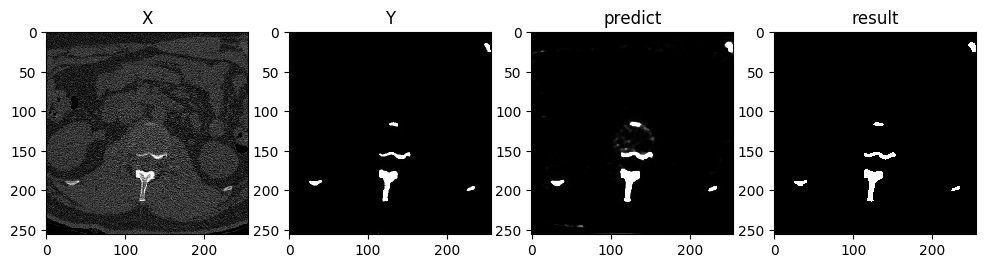

(1, 256, 256, 1)


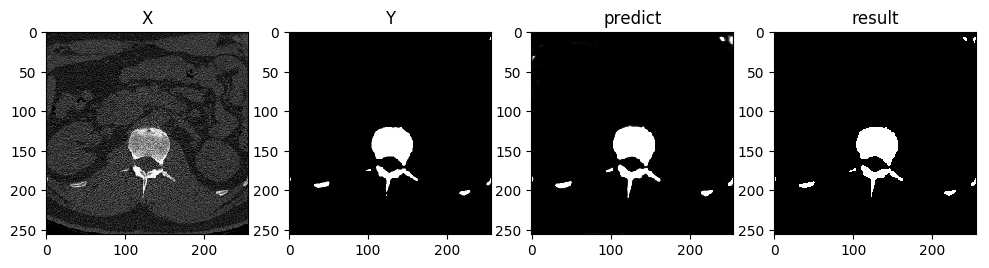

(1, 256, 256, 1)


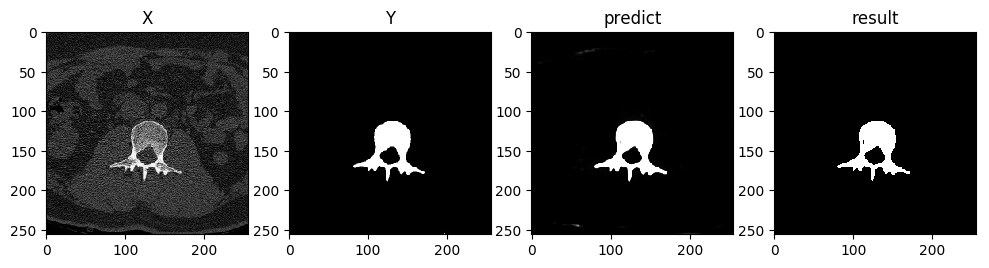

(1, 256, 256, 1)


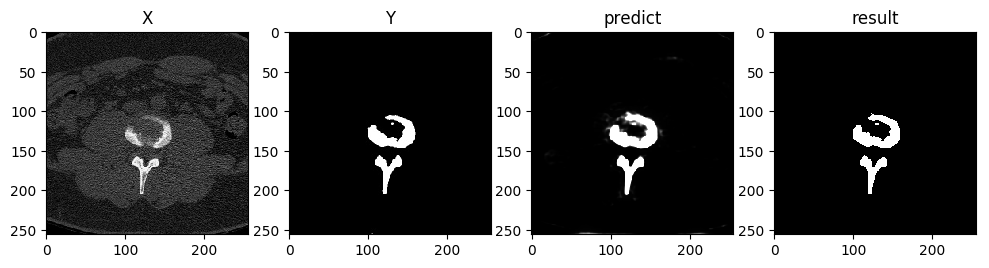

(1, 256, 256, 1)


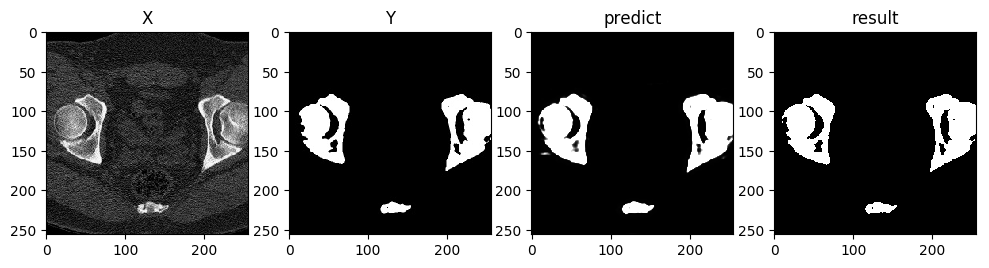

(1, 256, 256, 1)


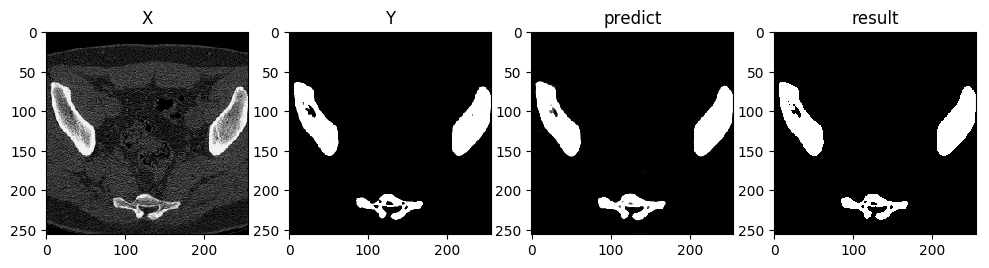

(1, 256, 256, 1)


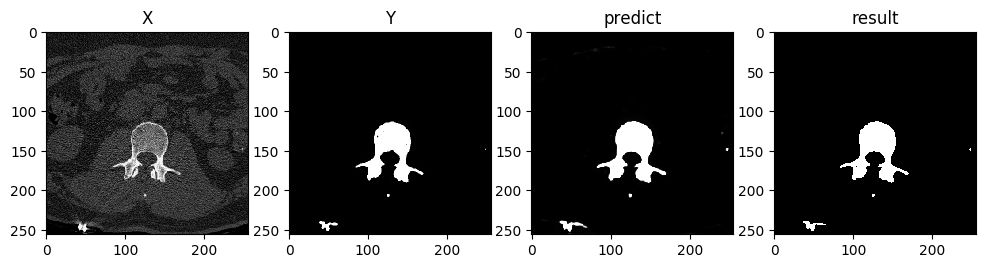

(1, 256, 256, 1)


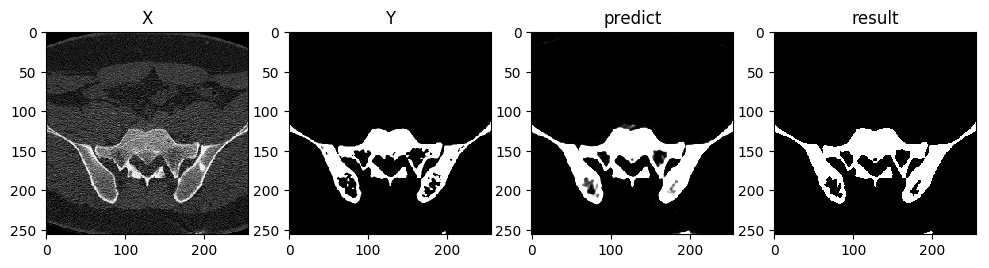

(1, 256, 256, 1)


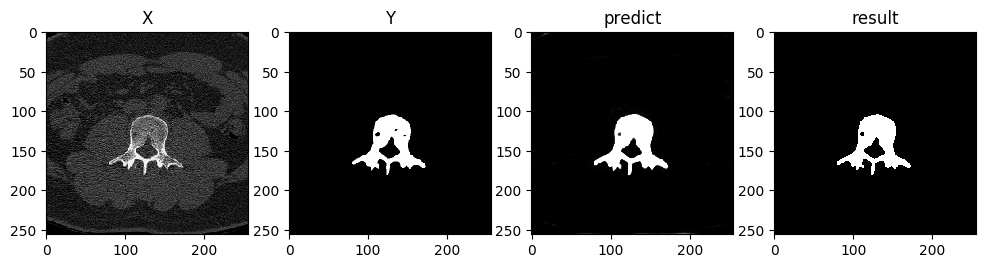

(1, 256, 256, 1)


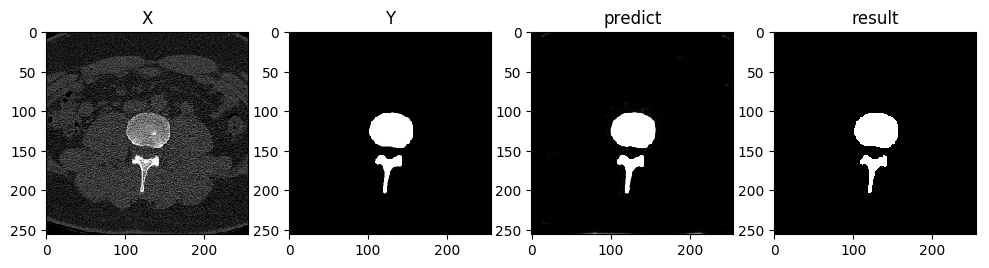

(1, 256, 256, 1)


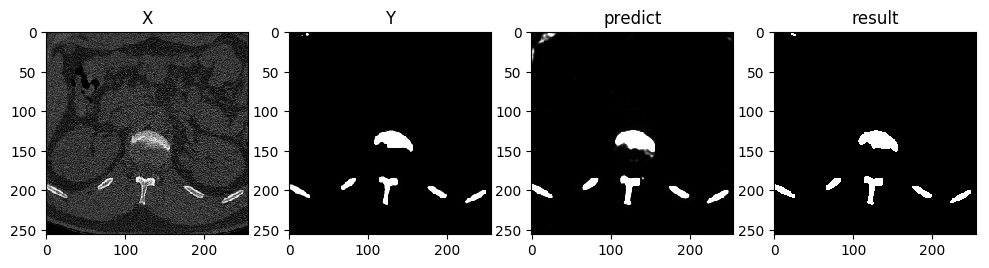

(1, 256, 256, 1)


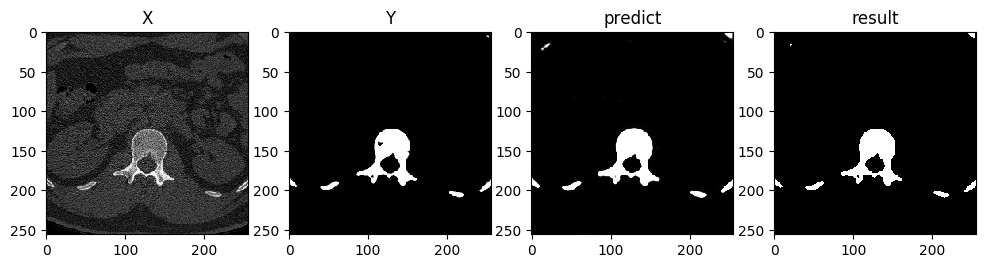

(1, 256, 256, 1)


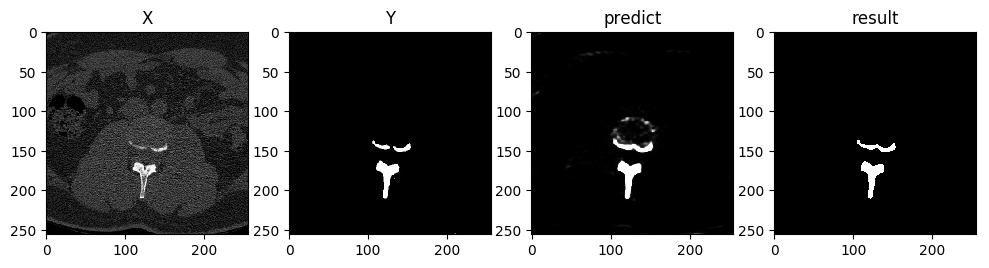

(1, 256, 256, 1)


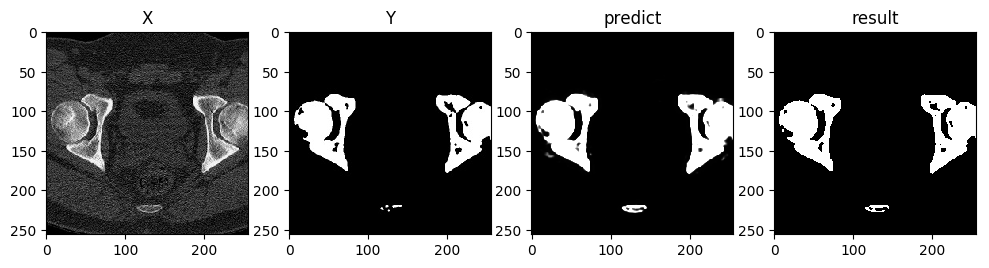

(1, 256, 256, 1)


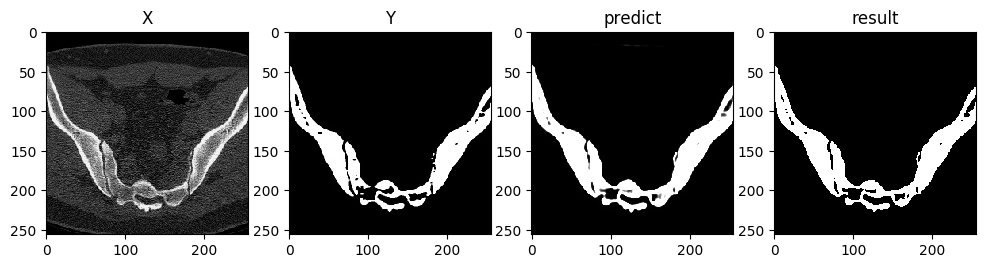

(1, 256, 256, 1)


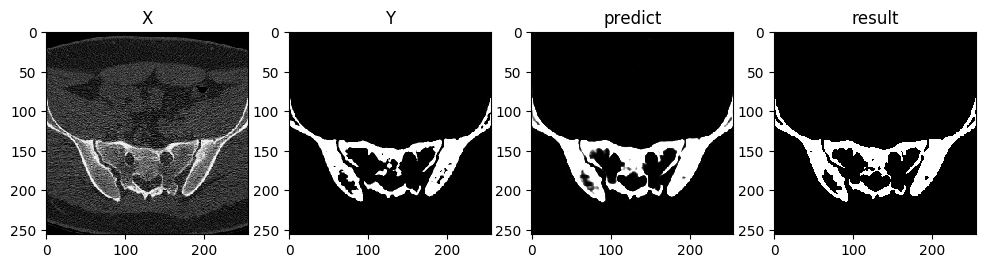

(1, 256, 256, 1)


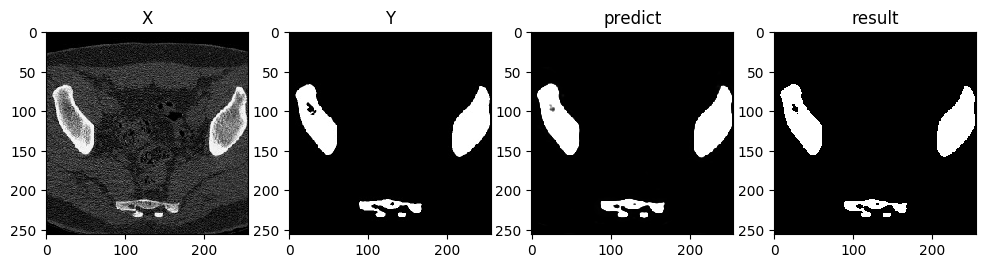

(1, 256, 256, 1)


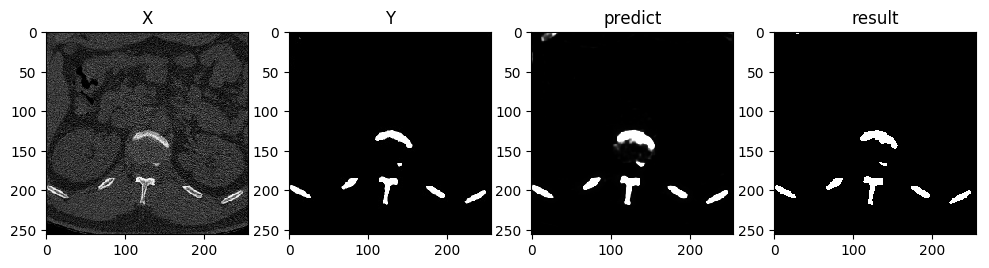

(1, 256, 256, 1)


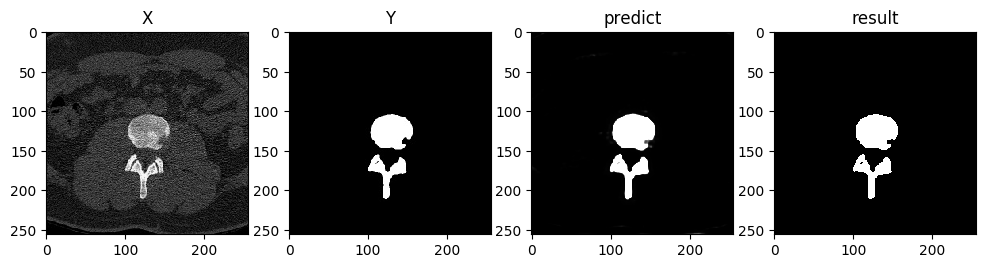

(1, 256, 256, 1)


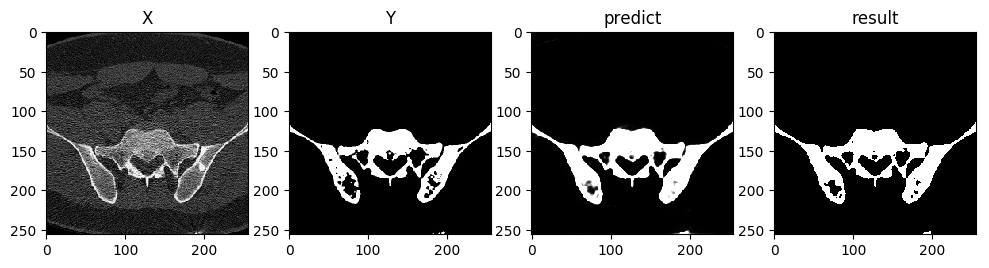

(1, 256, 256, 1)


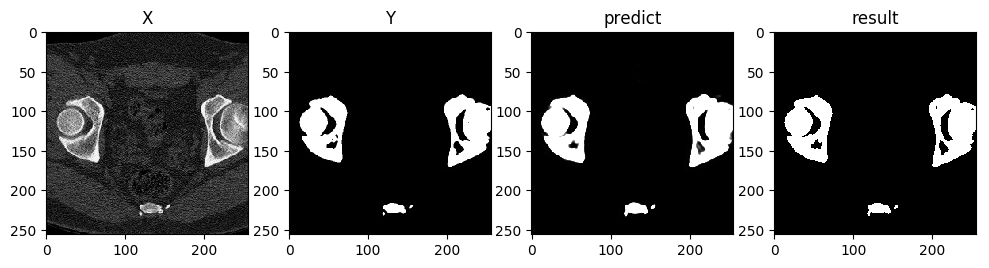

(1, 256, 256, 1)


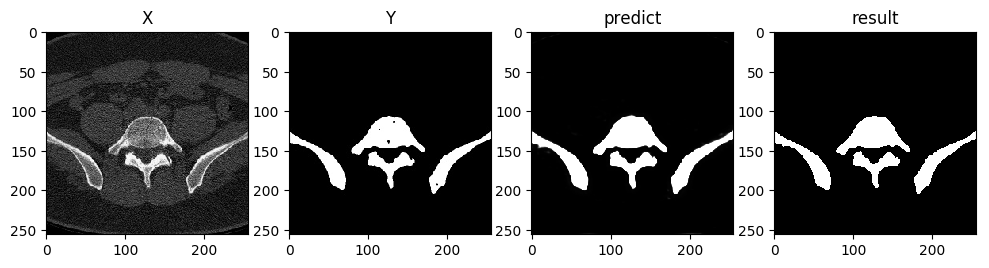

(1, 256, 256, 1)


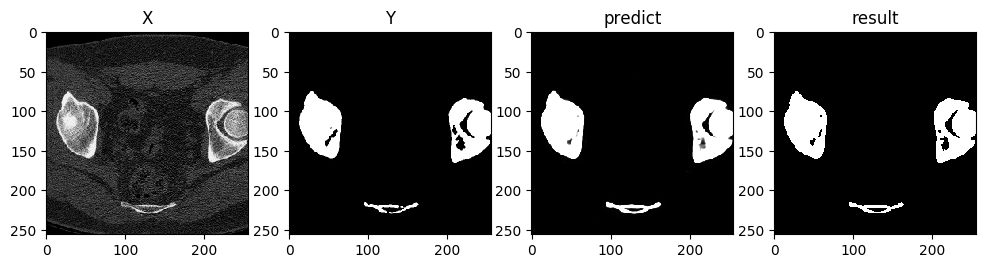

(1, 256, 256, 1)


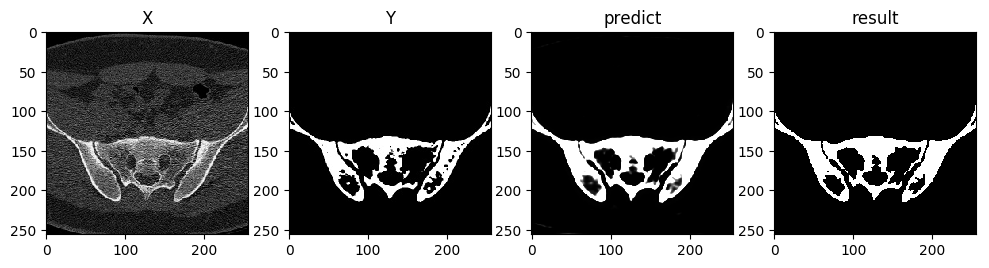

(1, 256, 256, 1)


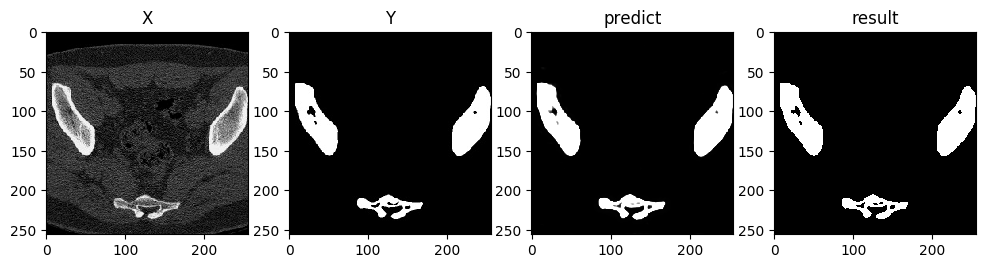

(1, 256, 256, 1)


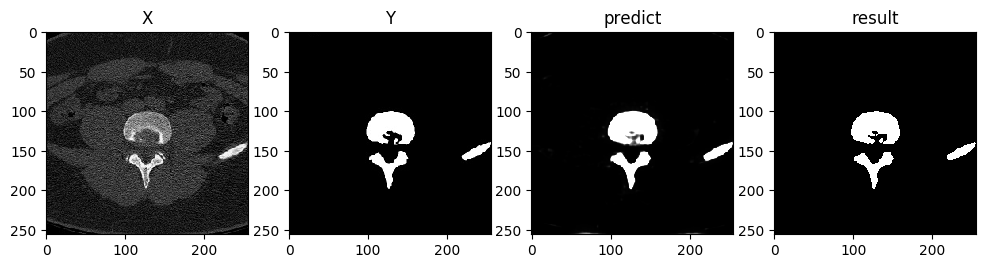

(1, 256, 256, 1)


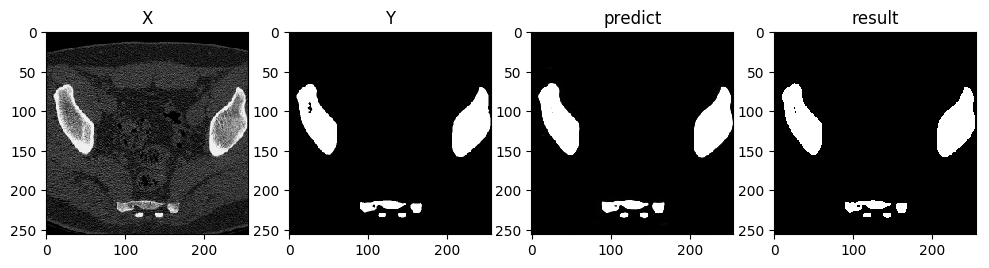

In [12]:
#num = 3
for num in range(0, 31):

    X = X_train[num:num+1]
    Y = Y_train[num:num+1]

    img = model.predict(X)
    img2 = img > 0.5
    print(img.shape)


    plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')

    plt.subplot(141), plt.title('X'), plt.imshow(X.reshape(size,size), cmap='gray')

    plt.subplot(142), plt.title('Y'), plt.imshow(Y.reshape(size,size), cmap='gray')

    plt.subplot(143), plt.title('predict'), plt.imshow(img.reshape(size,size), cmap='gray')

    plt.subplot(144), plt.title('result'), plt.imshow(img2.reshape(size,size), cmap='gray')

    plt.show()